In [9]:
# Import relevant libraries.

import argparse
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import xbpch
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics import ProgressBar
from matplotlib import colorbar, colors


In [10]:
# Name the xbpch files for the reference and new models
OLD = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.bpch'
NEW = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.new.bpch'

# Upload/open the data from the models 
OLD_ds = (xbpch.open_bpchdataset(OLD))
NEW_ds = (xbpch.open_bpchdataset(NEW))

# Read in the data for the observed sites
AnHgObs= pd.read_csv('~/Documents/HG/data/TGMSiteAnnual1.csv', na_values=(-9999))

/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [11]:
# Make a variable for the unit conversion factor to obtain ng/m^3
Unit_Conversion= 8.93


# Extract and add together Hg0 and Hg2 at the surface from the reference model multiplying by the unit converion factor 
# to obtain values for Total Gaseous Mercury.
OLD_Hg0 =((OLD_ds['IJ_AVG_S_Hg0'].isel(lev=0)) * Unit_Conversion)                              
OLD_Hg2 =((OLD_ds['IJ_AVG_S_Hg2'].isel(lev=0)) * Unit_Conversion)                
TGM_Old = (OLD_Hg0 + OLD_Hg2)


# Extract and add together Hg0 and Hg2 at the surface from the new model multiplying by the unit converion factor 
# to obtain values for Total Gaseous Mercury.
NEW_Hg0 =((NEW_ds['IJ_AVG_S_Hg0'].isel(lev=0) * Unit_Conversion))                         
NEW_Hg2 =((NEW_ds['IJ_AVG_S_Hg2'].isel(lev=0) * Unit_Conversion))
TGM_New = NEW_Hg0 + NEW_Hg2



In [12]:
# Define a function for Surface TGM with default variables set for such
def HgMeanSurfaceTGM (Variable=['IJ_AVG_S_Hg0', 'IJ_AVG_S_Hg2'], 
                      Units="$ng/m^2$", Unit_Conversion=8.93, Title="Surface TGM"):
    # Set levels for the colorbar in order to have a nonlinear scale.
    Levels= (0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50)
    
    # Create an if statement to differentiate between only one variable and a list of variables. 
    if type(Variable) is list and len(Variable) > 1:
        OLD_sum=0
        NEW_sum=0
        
        # Create a for loop to add each variable, extracting the mean of the variable in respect to time 
        # at surface level.
        for i in range(len(Variable)):
            tmpVar1 = ((OLD_ds[Variable[i]].isel(lev=0).mean('time')) * Unit_Conversion)
            OLD_sum = OLD_sum + tmpVar1
            tmpVar2 = ((NEW_ds[Variable[i]].isel(lev=0).mean('time')) * Unit_Conversion)
            NEW_sum = NEW_sum + tmpVar2
    else:
        # Extract the mean of only one variable in respect to time at surface level 
        NEW_sum = ((NEW_ds[Variable].isel(lev=0).mean('time')) * Unit_Conversion)
        OLD_sum = ((OLD_ds[Variable].isel(lev=0).mean('time')) * Unit_Conversion)
    
    
    # Find the absolute difference between the reference and new model.
    Abs_diff = NEW_sum - OLD_sum
    # Find the absolute maximum value of the absolute difference. 
    Abs_MaxVal= np.max(np.abs(Abs_diff))
    
    
    # Find the percent difference of the models.  
    Perc_diff = (Abs_diff / OLD_sum)*100
    # Find the absolute maximum value of the percent  difference. 
    Perc_MaxVal= np.max(np.abs(Perc_diff))
    
    
    
    # Plot the four graphs as subplots.
    plt.figure(figsize=(20,10))
    
    # Plot the reference model and use a geographical map.
    ax = plt.subplot(221, projection=ccrs.PlateCarree())
    im=OLD_sum.plot.contourf(x='lon',y='lat',ax=ax, transform=ccrs.PlateCarree(), levels= Levels, cmap='viridis', 
                             title= (Title), 
                             cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label':"Not Linear " + Units})  
    # Add a title 
    plt.title(' Reference Model Version: '+Title)     
    # Add the coastlines.
    ax.coastlines()
    
    
    
    # Plot the new model using a geographical map.       
    ax = plt.subplot(222, projection=ccrs.PlateCarree())
    im= NEW_sum.plot.contourf(x='lon',y='lat', cmap='viridis', transform=ccrs.PlateCarree(), ax=ax, levels= Levels,
                             cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label':"Not Linear " + Units})
    # Add a title.
    plt.title('New Model Version: '+ Title)
    # Add the coastlines.
    ax.coastlines()
    
    # Plot the absolute difference using a geograpical map.
    ax = plt.subplot(223, projection=ccrs.PlateCarree())
    im= Abs_diff.plot.imshow(x='lon',y='lat', ax=ax,transform=ccrs.PlateCarree(),  cmap='RdBu',
                             vmin=(-Abs_MaxVal), vmax=(Abs_MaxVal),
                          cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label': Units})
    # Add a title.
    plt.title("Absolute Difference")
    # Add the coastlines.
    ax.coastlines()
     
    # Plot the percent difference using a geographical map.
    ax = plt.subplot(224, projection=ccrs.PlateCarree())
    im= Perc_diff.plot.imshow(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap='RdBu',
                              vmin=(-Perc_MaxVal), vmax=(Perc_MaxVal),
                        cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label':"%" })
    # Add a title.
    plt.title("Percent Difference (%)")
    # Add the coastlines. 
    ax.coastlines()
    
    # Show the four subplots.
    graph= plt.show()
    
    # Return the four graphs. 
    return graph
    


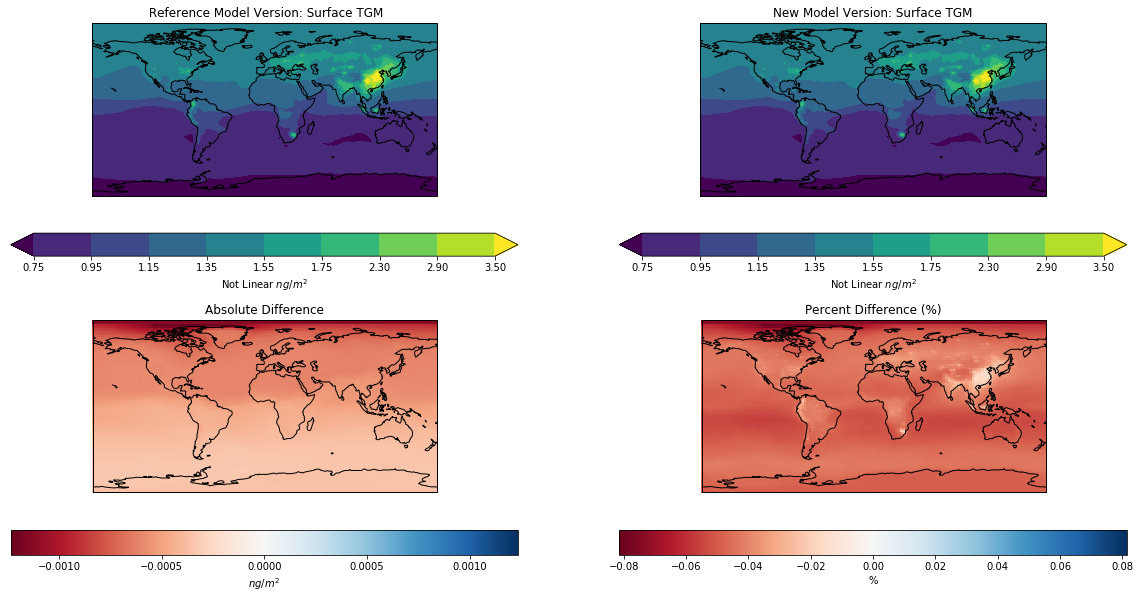

In [13]:

HgMeanSurfaceTGM()